## **Object Localization : Corn Disease Classification Using Tensorflow**

Nama Author : Kresna Fajri Wicaksana
<br>
Tanggal Mulai : 4 September 2024
<br>
Tanggal Selesai : ....
<br>
Nama Datasets : Corn Disease
<br>
Link Github Proyek : ....
<br>
Framework : Tensorflow

## **Impor Modul**

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import visualkeras
import random

from sklearn.model_selection import train_test_split

## **Data Preprocessing**

### **Splitting Data**

In [2]:
#Masukkan path dataset gambar
DATA_PATH = 'D:\My AI Project\Object Detection Plant Disease\data'

<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:2: SyntaxWarning: invalid escape sequence '\M'
C:\Users\INTEL\AppData\Local\Temp\ipykernel_15792\4016729331.py:2: SyntaxWarning: invalid escape sequence '\M'
  DATA_PATH = 'D:\My AI Project\Object Detection Plant Disease\data'


In [3]:
#Definisikan fitur gambar dan label
images = []
labels = []

for folder in os.listdir(DATA_PATH):
    folder_path = os.path.join(DATA_PATH,folder)
    if not os.path.isdir(folder_path):
        continue
    for image in os.listdir(folder_path):
        image_path = os.path.join(folder_path,image)
        images.append(image_path)

        labels.append(folder)

#Buat dataframe
dataframe_pic = pd.DataFrame({'image' : images, 
                    'label' :labels
})


In [4]:
#lakukan pembagian dataset dengan train_test_split
target = dataframe_pic['label']
train_df, test_df= train_test_split(dataframe_pic,train_size = 0.8, shuffle = True,random_state =123, stratify = target)
#cetak nilai hasil pembagian data
print(f'Train Data :{train_df.shape}')
print(f'Test Data Amount ; {test_df.shape}')

Train Data :(3350, 2)
Test Data Amount ; (838, 2)


In [5]:
print(train_df)

                                                  image           label
3946  D:\My AI Project\Object Detection Plant Diseas...         Healthy
3645  D:\My AI Project\Object Detection Plant Diseas...         Healthy
156   D:\My AI Project\Object Detection Plant Diseas...          Blight
2825  D:\My AI Project\Object Detection Plant Diseas...  Gray_Leaf_Spot
3515  D:\My AI Project\Object Detection Plant Diseas...         Healthy
...                                                 ...             ...
2166  D:\My AI Project\Object Detection Plant Diseas...     Common_Rust
3884  D:\My AI Project\Object Detection Plant Diseas...         Healthy
3588  D:\My AI Project\Object Detection Plant Diseas...         Healthy
3196  D:\My AI Project\Object Detection Plant Diseas...         Healthy
1653  D:\My AI Project\Object Detection Plant Diseas...     Common_Rust

[3350 rows x 2 columns]


In [6]:
#masukkan data gambar ke dalam Image Data Generator
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [7]:
train_generator = train_datagen.flow_from_dataframe(
            train_df,
            x_col = 'image',
            y_col = 'label',
            target_size = (224,224),
    #definisikan batch_size
            batch_size = 32,
            color_mode = 'rgb',
    #Atur shuffle = True, parameter ini akan mengacak gambar tiap kali pelatihan, sehingga mengurangi kemungkinan terjadinya overfitting.
            shuffle = True,
    #Karena kita akan melakukan penggolongan menjadi 3 kelas objek, maka kelas akan diatur menjadi 'categorical'
            class_mode = 'categorical',
            validate_filenames = True)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col = 'image',
    y_col = 'label',
    target_size = (224,224),
    batch_size = 32,
    color_mode = 'rgb',
    shuffle =False,
    class_mode = 'categorical',
    validate_filenames = True)

Found 3350 validated image filenames belonging to 4 classes.
Found 838 validated image filenames belonging to 4 classes.


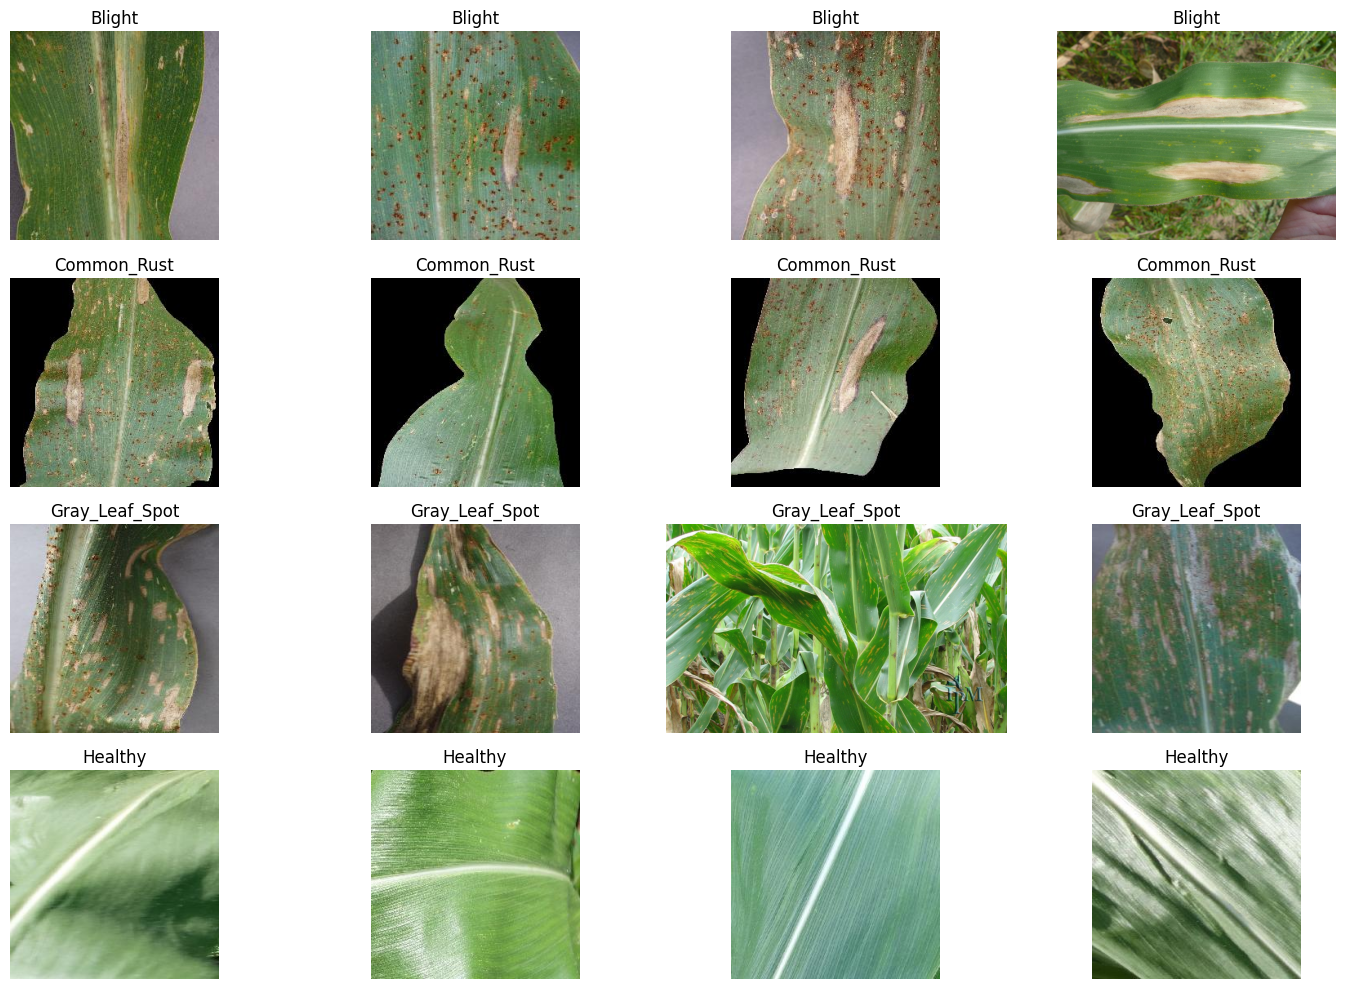

In [8]:
#Tampilkan gambar 
#buat matplotlib fig. dan sesuaikan ukuran menjadi baris dan kolom yang telah didefinisikan di kode sebelumnya
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_images_from_directory(directories, rows = 4, cols = 4):
    fig,axs = plt.subplots(rows, cols, figsize=(15,10))
    axs = axs.flatten()

    for i, directory in enumerate(os.listdir(directories)):
        for j in range(cols):
            try:
                image_path = os.path.join(directories,directory, random.choice(os.listdir(os.path.join(directories,directory))))
                img = plt.imread(image_path)
                axs[i*cols + j].imshow(img)
                axs[i*cols + j].axis('off')
                axs[i * cols + j].set_title(f'{directory}')
            except FileNotFoundError:
                print(f'Gambar tidak ditemukan di direktori {directory}')
    plt.tight_layout()
    plt.show()

#Gunakan fungsi
#directories = os.listdir(test_dir)
plot_images_from_directory(DATA_PATH, rows = 4, cols = 4)
                                      

## **Model Building : Customized Convolutional Neural Network**

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,BatchNormalization,Flatten,Dropout,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adamax

#Akan dibuat model seperti layaknya menulis fungsi dalam matematika aljabar, inilah gaya penulisan kode dengan menggunakan Functional API
#Model yang akan dibuat berfungsi sebagai base CNN model

def create_base_model():

    #Definisikan ukuran file input
    input= Input(shape=(224,224,3))

    #definisikan CNN bagian 1
    x = Conv2D(64,(3,3),strides=(1,1),activation='relu')(input)
    x2 = Conv2D(64,(3,3),strides=(1,1),activation='relu')(x)
    maxpool1 = MaxPooling2D(pool_size= (2,2))(x2)
    batch_norm1 = BatchNormalization()(maxpool1)

    #Definisikan CNN bagian 2
    x3 = Conv2D(64,(3,3),strides=(1,1),activation='relu')(batch_norm1)
    x4 = Conv2D(64,(3,3),strides=(1,1),activation='relu')(x3)
    maxpool2=MaxPooling2D(pool_size=(2,2))(x4)
    batch_norm2 = BatchNormalization()(maxpool2)

    #Definisikan CNN bagian 3
    x5 = Conv2D(64,(3,3),strides = (1,1),activation='relu')(batch_norm2)
    x6 = Conv2D(64,(3,3),strides = (1,1),activation='relu')(x5)
    x7 = Conv2D(64,(3,3),strides = (1,1),activation='relu')(x6)
    maxpool4 = MaxPooling2D(pool_size = (2,2))(x7)
    batch_norm3 = BatchNormalization()(maxpool4)
    DO1 = Dropout(0.3)(batch_norm3)

    #Definisikan CNN bagian 3
    x8 = Conv2D(32,(3,3),strides = (1,1),activation='relu')(DO1)
    x9 = Conv2D(32,(3,3),strides = (1,1),activation='relu')(x8)
    x10 = Conv2D(32,(3,3),strides = (1,1),activation='relu')(x9)
    maxpool5 = MaxPooling2D(pool_size = (2,2))(x10)
    batch_norm4 = BatchNormalization()(maxpool5)
    DO2= Dropout(0.3)(batch_norm4)

    #Definisikan CNN bagian 3
    x11 = Conv2D(32,(3,3),strides = (1,1),activation='relu')(DO2)
    x12 = Conv2D(32,(3,3),strides = (1,1),activation='relu')(x11)
    maxpool6 = MaxPooling2D(pool_size = (2,2))(x12)
    batch_norm5 = BatchNormalization()(maxpool6)
    
    #Lakukan pengurangan dimensi hingga menjadi 1 dimensi data
    flatten_layer = Flatten()(batch_norm5)

    #Lapisan Dropout 5
    DO3 = Dropout(0.4)(flatten_layer)

    #output layer
    Dense1 = Dense(512,activation='relu',kernel_regularizer= tf.keras.regularizers.l2(0.0001))(DO3)
    Dense2 = Dense(512,activation='relu',kernel_regularizer= tf.keras.regularizers.l2(0.0001))(Dense1)
    output_layer = Dense(4,activation='softmax',kernel_regularizer= tf.keras.regularizers.l2(0.0001))(Dense2)
    
    #Bungkus semua lapisan yang telah terdefinisi dalam 1 model yang terintegrasi
    base_cnn_model = Model(inputs = input, outputs = output_layer)

    return base_cnn_model
    

In [10]:
#definisikan modelnya
cnn_model = create_base_model()

#kompilasi modelnya
cnn_model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adamax',
              metrics=['accuracy'])

#ringkasan model
cnn_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 110, 110, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 53, 53, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 47, 47, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 23, 23, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 21, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 19, 19, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 17, 17, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 6, 6, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 32)       │         9,24

 Total params: 610,596 (2.33 MB)

 Trainable params: 610,084 (2.33 MB)

 Non-trainable params: 512 (2.00 KB)

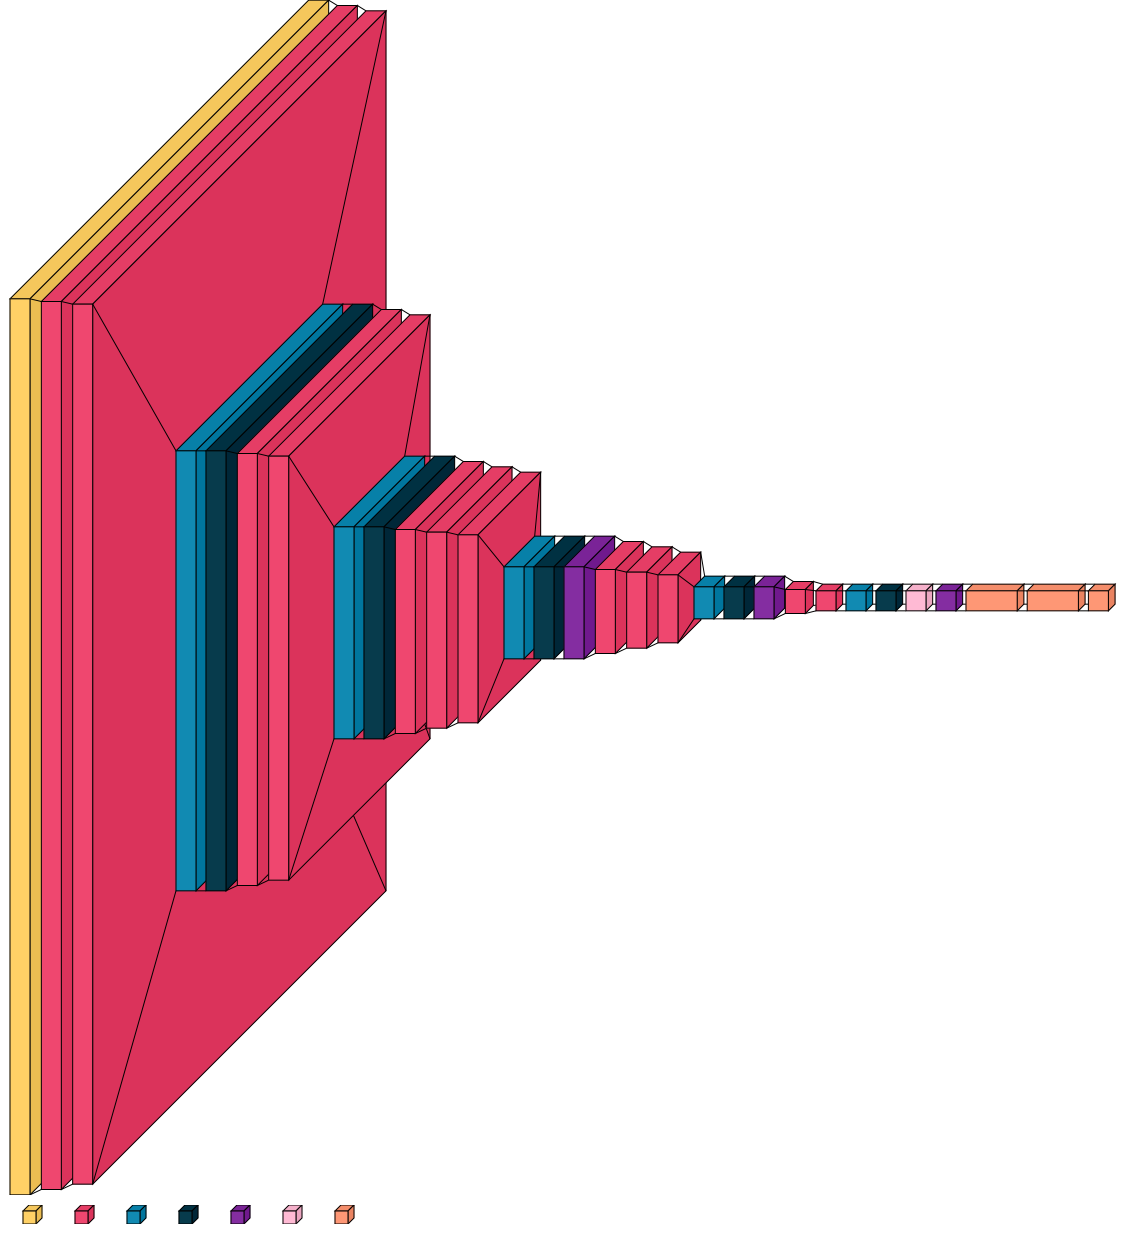

In [22]:
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 12)  # using comic sans is strictly prohibited!
visualkeras.layered_view(cnn_model, legend=True, font=font)


### **Model Training**

Model CNN ini akan dilatih dengan menggunakan data training terlebih dahulu. Setelahnya baru dilakukan proses prediksi langsung dengan data test. Akan digunakan juga metode callback. Callback berfungsi untuk menghentikan proses pelatihan agar model tidak mengalami overfitting(model yang terlalu menghafal data latih, sehingga akurasi menurun saat proses prediksi). Dengan menggunakan module EarlyStopping yang sudah diimpor saat proses pembangunan model, sekarang kita hanya perlu mendelegasikan modulnya dalam sebuah variabel yang akan disisipkan saat pelatihan model.

In [11]:
batch_size = 32
from tensorflow.keras.callbacks import Callback

#definisikan callback 
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.96):
            print("\nReached 94% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

#definisikan callback dengan EarlyStopping
#early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 10, mode = 'max')

#Latih model
history = cnn_model.fit(
    train_generator,
    epochs = 30,
    batch_size = batch_size,
    verbose = 1,
    validation_data = test_generator,
    callbacks = callbacks
)

Epoch 1/30


c:\Users\INTEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


105/105 ━━━━━━━━━━━━━━━━━━━━ 862s 8s/step - accuracy: 0.6469 - loss: 0.9563 - val_accuracy: 0.3413 - val_loss: 1.4589
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 897s 9s/step - accuracy: 0.8113 - loss: 0.5374 - val_accuracy: 0.5990 - val_loss: 0.9955
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 666s 6s/step - accuracy: 0.8722 - loss: 0.4174 - val_accuracy: 0.6993 - val_loss: 0.8948
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 664s 6s/step - accuracy: 0.8588 - loss: 0.4442 - val_accuracy: 0.8294 - val_loss: 0.5092
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 660s 6s/step - accuracy: 0.8785 - loss: 0.4149 - val_accuracy: 0.6706 - val_loss: 0.9246
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 657s 6s/step - accuracy: 0.8793 - loss: 0.3958 - val_accuracy: 0.8568 - val_loss: 0.4691
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 657s 6s/step - accuracy: 0.8907 - loss: 0.3475 - val_accuracy: 0.8473 - val_loss: 0.5804
Epoch 8/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 656s 6s/step - accuracy: 0.9041 - loss: 0.3480 - val_accuracy: 0.878

### **Accuracy and Loss Curve**

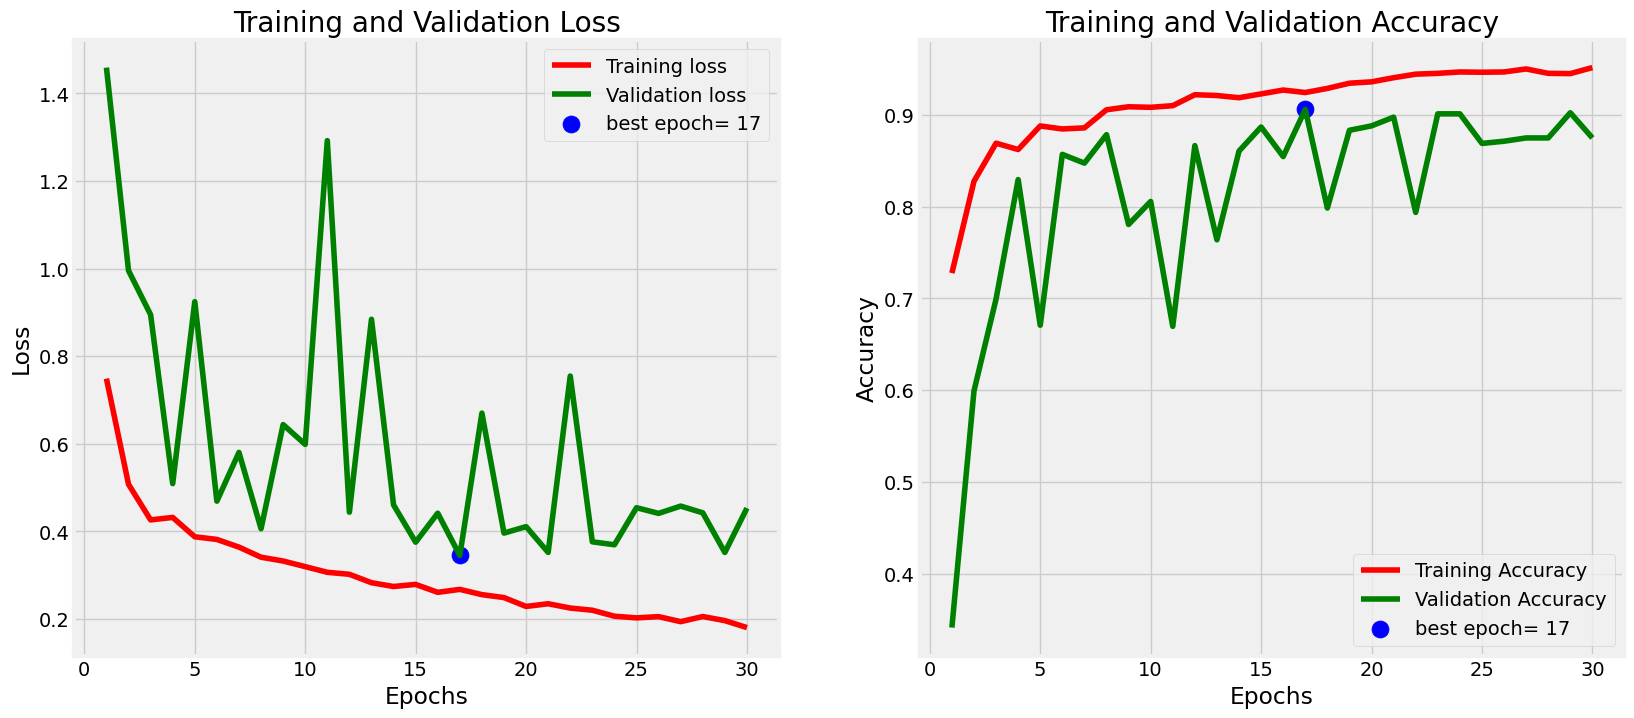

In [12]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

### **Accuracy and Loss Score**

In [13]:
#import paket untuk classification report

from sklearn.metrics import classification_report

def count_images(folder_path):
  """
  Fungsi untuk menghitung jumlah gambar dalam sebuah folder dan subfoldernya

  Args:
    folder_path: Path ke folder yang ingin dihitung jumlah gambarnya

  Returns:
    Jumlah gambar
  """

  count = 0
  for root, dirs, files in os.walk(folder_path):
    for file in files:
      if file.endswith(('.jpg', '.jpeg', '.png', '.bmp')):  # Sesuaikan dengan ekstensi gambar Anda
        count += 1
  return count


In [15]:
#import paket classifcation report dan confusion matrix
#tst_length = count_images(test_dir)
#test_batch_size = max(sorted([tst_length // n for n in range(1, tst_length + 1)if tst_length % n == 0  and tst_length/n<=80]))
#tst_steps = tst_length // test_batch_size

#Evaluasi Model
loss,accuracy = cnn_model.evaluate(test_generator)


#Proses prediksi gambar berdasarkan kla
preds = cnn_model.predict(test_generator)
y_pred = np.argmax(preds,axis = 1)

#definisikan kelas
classes = list(train_generator.class_indices.keys())

#Buat laporan hasil klasifikasi
print(classification_report(test_generator.classes, y_pred, target_names=classes ))

27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 976ms/step - accuracy: 0.8661 - loss: 0.4724
27/27 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step
                precision    recall  f1-score   support

        Blight       0.91      0.72      0.81       229
   Common_Rust       0.94      0.94      0.94       261
Gray_Leaf_Spot       0.67      0.77      0.72       115
       Healthy       0.89      1.00      0.94       233

      accuracy                           0.87       838
     macro avg       0.85      0.86      0.85       838
  weighted avg       0.88      0.87      0.87       838



27/27 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step


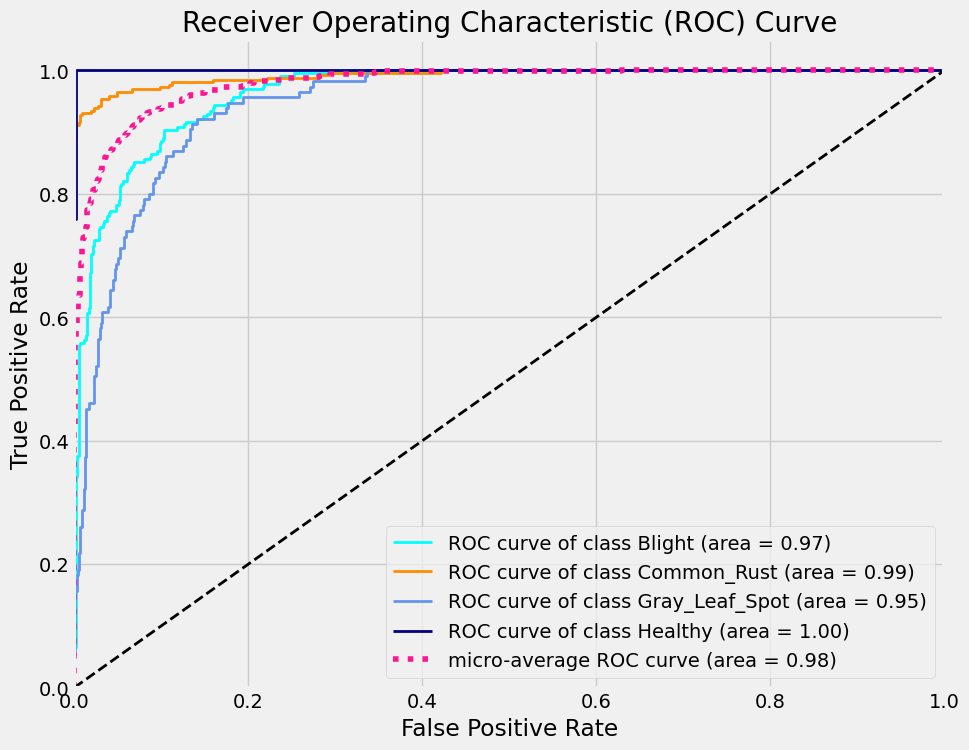

In [16]:
#cetak grafik ROC-AUC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import itertools


n_classes = len(classes)

y_true = label_binarize(test_generator.classes, classes=range(n_classes))
y_pred_probs = cnn_model.predict(test_generator)  # Ensure these are the predicted probabilities

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'deeppink', 'seagreen'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [17]:
#Akan dibuat ROC AUC curve
from sklearn.metrics import roc_auc_score

auc_scores = {}
for i in range(n_classes):
    auc_scores[classes[i]] = roc_auc_score(y_true[:, i], y_pred_probs[:, i])

for class_name, auc_score in auc_scores.items():
    print(f"AUC for class {class_name}: {auc_score:.2f}")

micro_auc = roc_auc_score(y_true, y_pred_probs, average="micro")
print(f"Micro-average AUC: {micro_auc:.2f}")

macro_auc = roc_auc_score(y_true, y_pred_probs, average="macro")
print(f"Macro-average AUC: {macro_auc:.2f}")

AUC for class Blight: 0.97
AUC for class Common_Rust: 0.99
AUC for class Gray_Leaf_Spot: 0.95
AUC for class Healthy: 1.00
Micro-average AUC: 0.98
Macro-average AUC: 0.98


### **Model Comparison : VGG16**

Tadi kita telah melihat tingkat akurasi model yang dibuat sendiri. Sekarang, akan dilakukan perbandingan dengan model lain yang ada di dalam framework Tensorflow yaitu VGG16.

In [24]:
from keras.applications import VGG16


#Definisikan model vgg16
vgg16_base = VGG16(weights = 'imagenet',include_top = False, input_shape=(224,224,3))
vgg16_base.trainable = False

#Definisikan input
inputs = Input(shape=(224,224,3))

x = vgg16_base(inputs, training=False)
flatten_layer = Flatten()(x)
Dense1 = Dense(128,activation='relu')(flatten_layer)
DO1 = Dropout(0.5)(Dense1)

output_layer = Dense(4,activation='softmax')(DO1)

#Bungkus seluruh layer dalam satu model
vgg16_model = Model(inputs, outputs = output_layer)

#Compile model
vgg16_model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)



vgg16_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,596 (68.38 MB)

 Trainable params: 3,211,908 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

c:\Users\INTEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


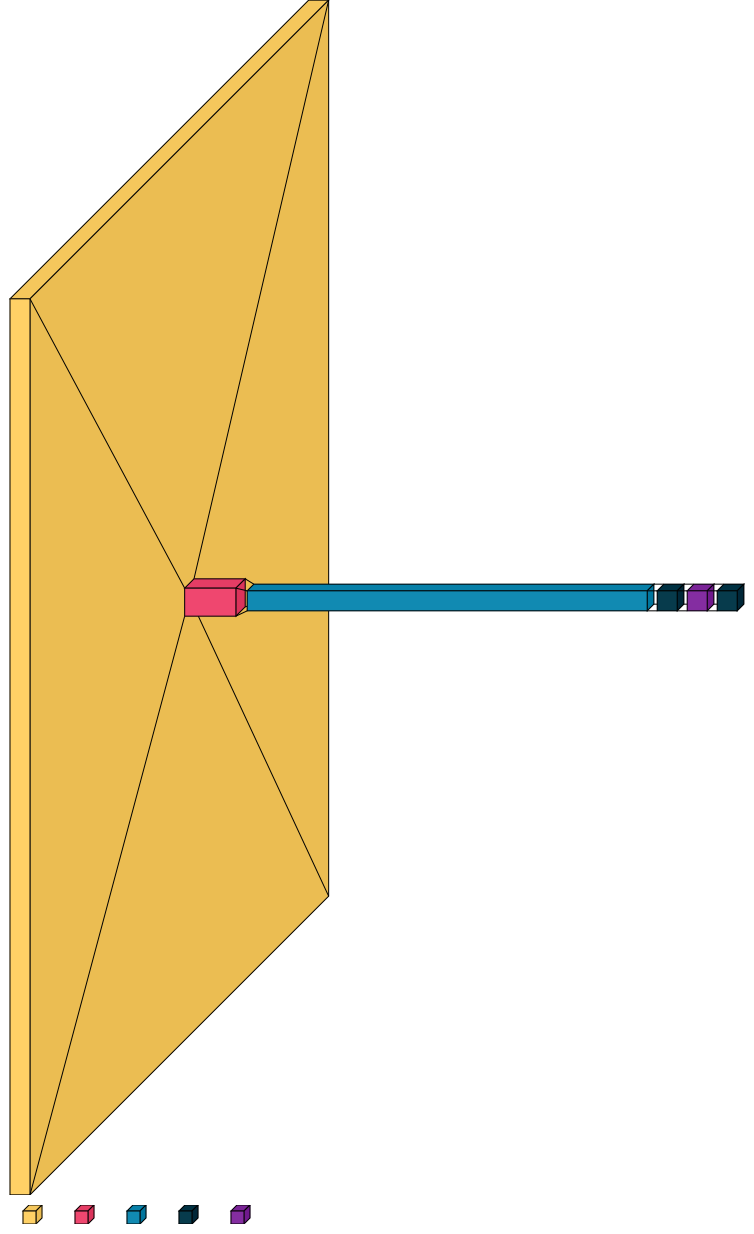

In [25]:
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 12)  # using comic sans is strictly prohibited!
visualkeras.layered_view(vgg16_model, legend=True, font=font)


In [15]:
#fitting model
vgg16_model.fit(train_generator, epochs = 10, validation_data = test_generator)

Epoch 1/10


c:\Users\INTEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


105/105 ━━━━━━━━━━━━━━━━━━━━ 846s 8s/step - accuracy: 0.7425 - loss: 5.3383 - val_accuracy: 0.8305 - val_loss: 0.3833
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 700s 7s/step - accuracy: 0.8399 - loss: 0.4471 - val_accuracy: 0.8831 - val_loss: 0.2834
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 745s 7s/step - accuracy: 0.8513 - loss: 0.4521 - val_accuracy: 0.8926 - val_loss: 0.3039
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 729s 7s/step - accuracy: 0.8753 - loss: 0.3845 - val_accuracy: 0.8902 - val_loss: 0.3216
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 681s 6s/step - accuracy: 0.8732 - loss: 0.3452 - val_accuracy: 0.8986 - val_loss: 0.3415
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 659s 6s/step - accuracy: 0.8948 - loss: 0.2650 - val_accuracy: 0.8938 - val_loss: 0.3607
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 616s 6s/step - accuracy: 0.9049 - loss: 0.3335 - val_accuracy: 0.8866 - val_loss: 0.3671
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 601s 6s/step - accuracy: 0.8949 - loss: 0.2791 - val_accuracy: 0.891

In [16]:
#cek akurasi
loss,accuracy = vgg16_model.evaluate(test_generator)

27/27 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step - accuracy: 0.8847 - loss: 0.4163


In [17]:
#import paket classifcation report dan confusion matrix
from sklearn.metrics import classification_report

preds = vgg16_model.predict(test_generator)
y_pred = np.argmax(preds,axis = 1)

#definisikan kelas
classes = list(train_generator.class_indices.keys())

#Buat laporan hasil klasifikasi
print(classification_report(test_generator.classes, y_pred, target_names=classes ))

27/27 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step
                precision    recall  f1-score   support

        Blight       0.83      0.87      0.85       229
   Common_Rust       0.98      0.92      0.95       261
Gray_Leaf_Spot       0.72      0.73      0.73       115
       Healthy       0.97      0.99      0.98       233

      accuracy                           0.90       838
     macro avg       0.88      0.88      0.88       838
  weighted avg       0.90      0.90      0.90       838



27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step


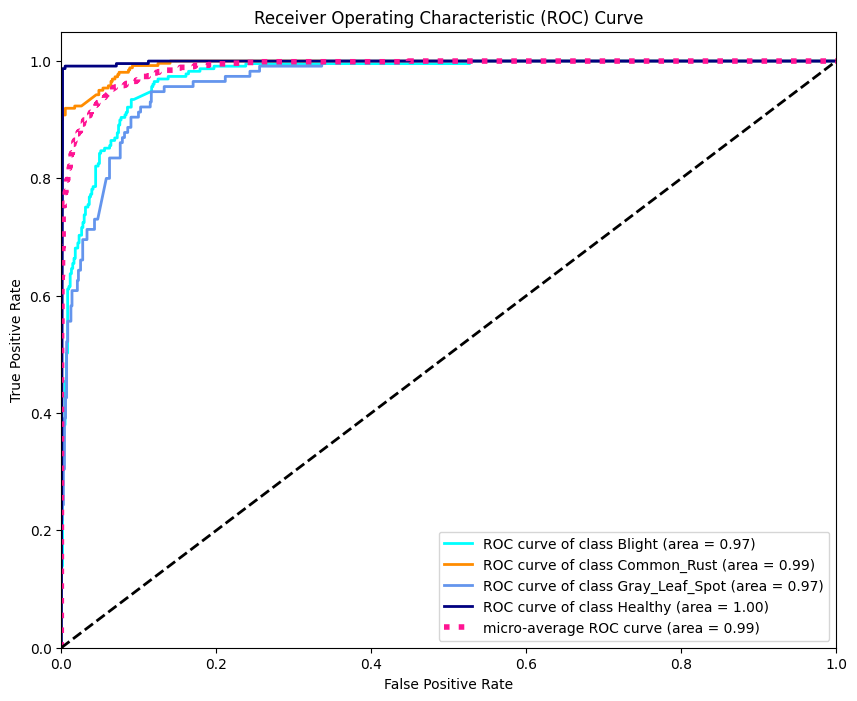

In [18]:
#cetak grafik ROC-AUC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import itertools


n_classes = len(classes)

y_true = label_binarize(test_generator.classes, classes=range(n_classes))
y_pred_probs = vgg16_model.predict(test_generator)  # Ensure these are the predicted probabilities

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'deeppink', 'seagreen'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### **Model Comparison : ResNet50**

In [11]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

#Definisikan model dengan fungsi beban dari ImageNet dengan ukuran input gambar 224 x 224 dengan 3 channel warna RGB
resnet50_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (224,224,3))

for layer in resnet50_model.layers:
    layer.trainable = False

output_layer = resnet50_model.output 
output_layer = GlobalAveragePooling2D()(output_layer)
prediction_layer = Dense(4,activation='softmax')(output_layer)

resnet50_model = Model(inputs = resnet50_model.input, outputs = prediction_layer)


#Kompilasi model dengan fungsi loss berupa categorical crossentropy dan optimizer Adam
resnet50_model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [12]:
resnet50_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

c:\Users\INTEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


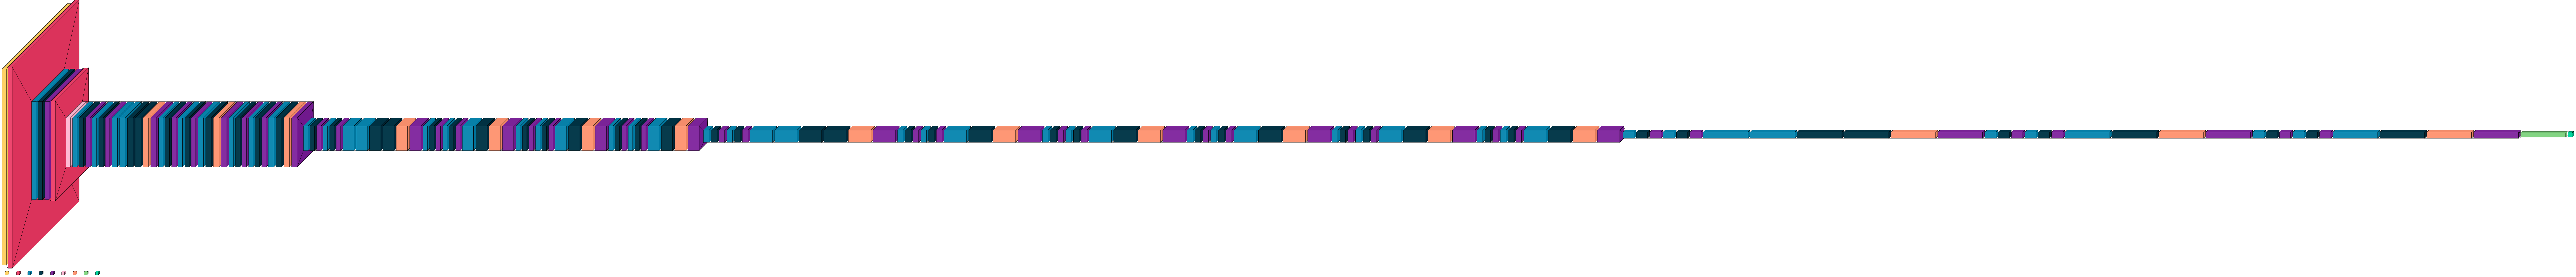

In [26]:
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 12)  # using comic sans is strictly prohibited!
visualkeras.layered_view(resnet50_model, legend=True, font=font)

In [14]:
#Fitting Model
resnet_history = resnet50_model.fit(train_generator,
                   epochs = 10,
                   validation_data = test_generator)


Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8968 - loss: 0.2623

c:\Users\INTEL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


105/105 ━━━━━━━━━━━━━━━━━━━━ 312s 3s/step - accuracy: 0.8969 - loss: 0.2621 - val_accuracy: 0.9129 - val_loss: 0.2272
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - accuracy: 0.9488 - loss: 0.1557 - val_accuracy: 0.9153 - val_loss: 0.2007
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 373s 4s/step - accuracy: 0.9582 - loss: 0.1280 - val_accuracy: 0.9224 - val_loss: 0.1958
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 428s 4s/step - accuracy: 0.9547 - loss: 0.1235 - val_accuracy: 0.9260 - val_loss: 0.1848
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 403s 4s/step - accuracy: 0.9715 - loss: 0.0928 - val_accuracy: 0.9260 - val_loss: 0.1842
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 356s 3s/step - accuracy: 0.9664 - loss: 0.0957 - val_accuracy: 0.9308 - val_loss: 0.1771
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - accuracy: 0.9758 - loss: 0.0771 - val_accuracy: 0.9260 - val_loss: 0.1801
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 285s 3s/step - accuracy: 0.9813 - loss: 0.0680 - val_accuracy: 0.929

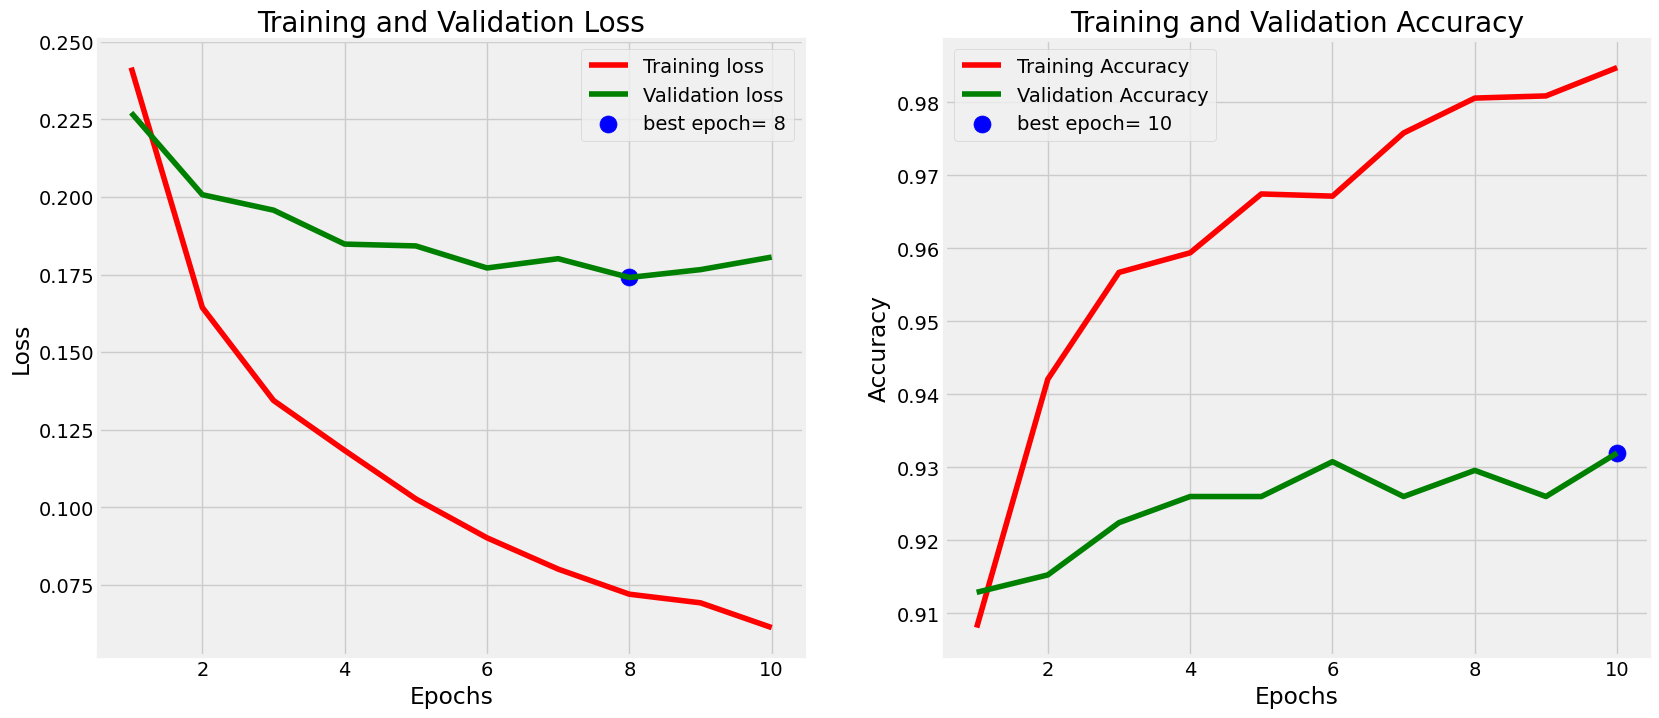

In [15]:
tr_acc = resnet_history.history['accuracy']
tr_loss = resnet_history.history['loss']
val_acc = resnet_history.history['val_accuracy']
val_loss = resnet_history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step


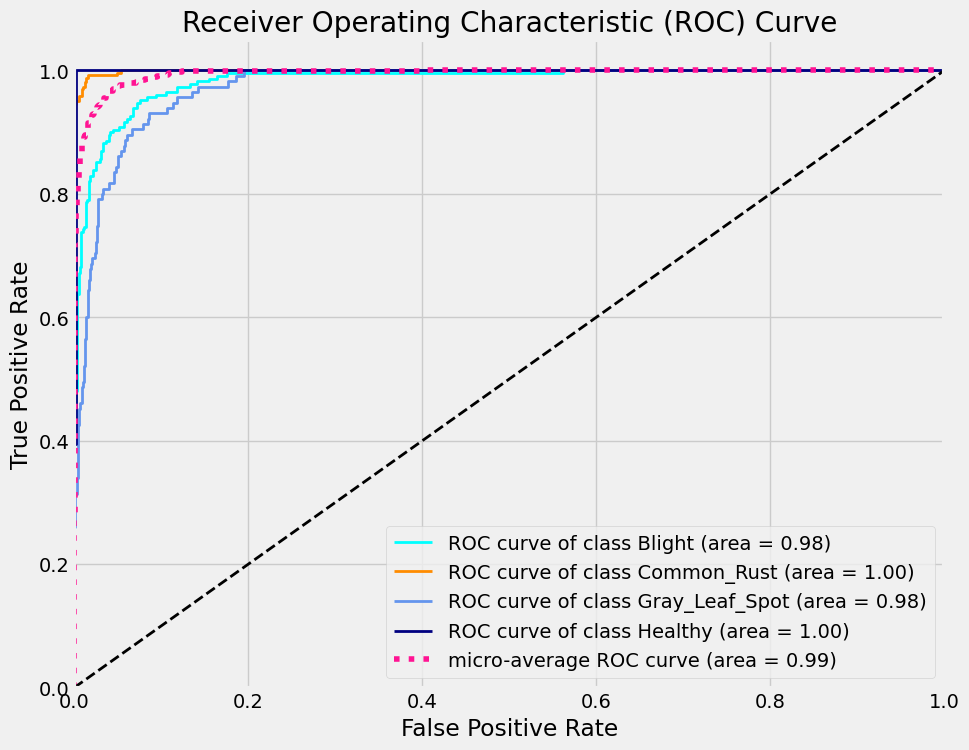

In [17]:
#cetak grafik ROC-AUC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import itertools


classes = list(train_generator.class_indices.keys())

n_classes = len(classes)

y_true = label_binarize(test_generator.classes, classes=range(n_classes))
y_pred_probs = resnet50_model.predict(test_generator)  # Ensure these are the predicted probabilities

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))
colors = itertools.cycle(['aqua', 'darkorange', 'cornflowerblue', 'navy', 'deeppink', 'seagreen'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
         ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## **Conclusion**

Berdasarkan perbandingan dari ketiga model, diketahui bahwa model **ResNet50** memiliki waktu untuk mencapai tingkat akurasi tinggi lebih cepat dibandingkan model CNN Custom yang saya buat dan juga model VGG16. Hanya dengan 10 epoch, **Resnet50** mampu mencapai akurasi di data uji sebesar 93%, sedangkan **VGG16** hanya mampu mencapai 91%. Model **Custom CNN** yang saya buat hanya mencapai 80% tingkat akurasi pada data uji dengan jumlah epoch yang sama.